# Topic Modeling with LDA on Columbia President Emails
This notebook compares emails from Katrina Armstrong and Minouche Shafik using topic modeling to understand thematic differences.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
#import seaborn as sns
import string

# Load email content
df_katrina = pd.read_excel("Katrina.xlsx")
df_minouche = pd.read_excel("Minouche.xlsx")

# Preview data
df_katrina.head(), df_minouche.head()

(                                               Title             Date  \
 0                 Sharing Progress on Our Priorities  3/21/2025 16:09   
 1                                     Our Next Steps  3/19/2025 12:32   
 2                     Standing Together for Columbia  3/15/2025 16:57   
 3  Update to Our Community Regarding DHS Activity...  3/13/2025 20:58   
 4  Columbia's Commitment to Our International Com...  3/13/2025 15:00   
 
                                              Content  
 0  Dear fellow members of the Columbia community:...  
 1  Dear fellow members of the Columbia community:...  
 2  Dear fellow members of our Columbia community:...  
 3  Dear fellow members of the Columbia community:...  
 4  Dear fellow members of the Columbia community:...  ,
                                                Title                Date  \
 0        Announcement from President Minouche Shafik 2024-08-15 00:00:50   
 1                           Update for Our Community 2024-07-2

In [3]:
# Preprocessing
def preprocess(texts):
    processed = []
    for doc in texts:
        doc = str(doc).lower()
        doc = ''.join([ch for ch in doc if ch not in string.punctuation])
        tokens = doc.split()
        tokens = [word for word in tokens if len(word) > 2]
        processed.append(' '.join(tokens))
    return processed

katrina_emails = preprocess(df_katrina['Content'].dropna())
minouche_emails = preprocess(df_minouche['Content'].dropna())
corpus = katrina_emails + minouche_emails
labels = ['Katrina'] * len(katrina_emails) + ['Minouche'] * len(minouche_emails)

# Vectorization
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(corpus)

In [10]:
# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Extract top words per topic
words = vectorizer.get_feature_names_out()
topics = []
for idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]
    topics.append(top_words)

# Display top words
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {', '.join(topic)}")

Topic 1: campus, students, safety, york, city, access, time, continue, academic, work
Topic 2: students, faculty, support, staff, moment, great, world, important, values, life
Topic 3: college, students, student, antisemitism, jewish, campus, life, academic, city, forward
Topic 4: students, faculty, campus, support, work, academic, mission, staff, rules, leadership
Topic 5: campus, mission, students, academic, commitment, open, freedom, work, city, values


## I asked ChatGPT to summarize each topic:

Topic 1: Student Safety and Campus Accessibility

Topic 2: Community Support and Shared Values

Topic 3: Antisemitism and Campus Response

Topic 4: Institutional Mission and Leadership Support

Topic 5: Freedom of Expression and University Values

<Figure size 1200x600 with 0 Axes>

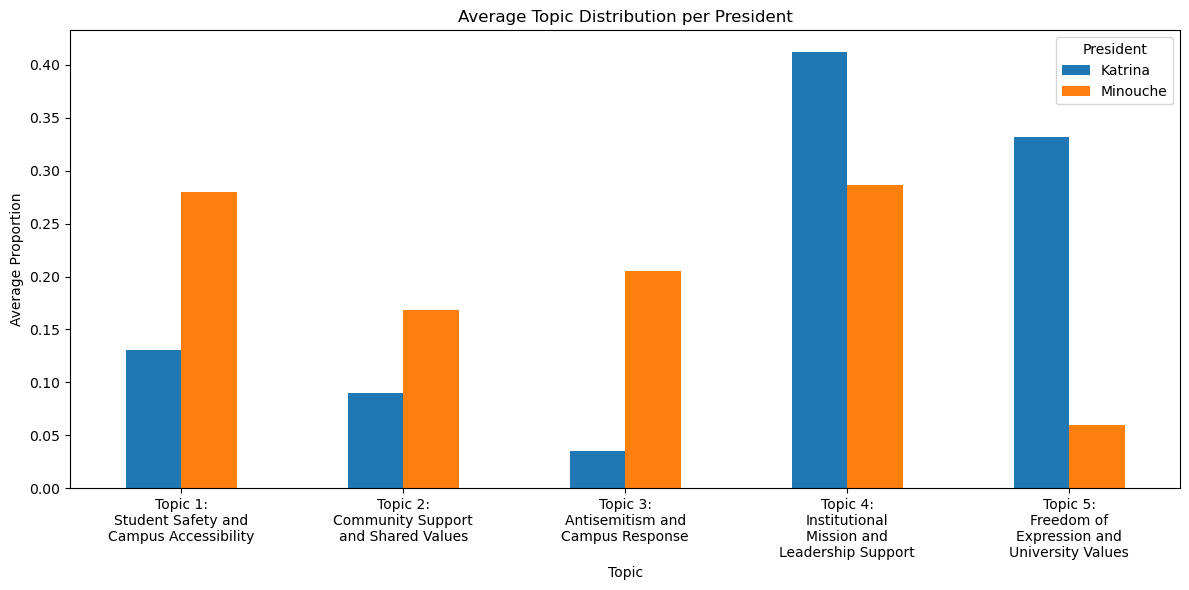

In [16]:
import textwrap

# Assign topics to documents
doc_topics = lda.transform(doc_term_matrix)
df_topics = pd.DataFrame(doc_topics, columns=[f"Topic {i+1}" for i in range(lda.n_components)])
df_topics['Label'] = labels

# Average topic distribution per person
avg_topics = df_topics.groupby("Label").mean().T

# Define descriptive topic labels
phrases = [
    "Student Safety and Campus Accessibility",
    "Community Support and Shared Values",
    "Antisemitism and Campus Response",
    "Institutional Mission and Leadership Support",
    "Freedom of Expression and University Values"
]

# Apply labels to index
wrapped_labels = [f"Topic {i+1}:\n" + "\n".join(textwrap.wrap(label, width=20)) for i, label in enumerate(phrases)]
avg_topics.index = wrapped_labels

# Plot
plt.figure(figsize=(12, 6))
avg_topics.plot(kind='bar', figsize=(12, 6))
plt.title("Average Topic Distribution per President")
plt.ylabel("Average Proportion")
plt.xlabel("Topic")
plt.xticks(rotation=0)
plt.legend(title="President")
plt.tight_layout()
plt.show()

# Significance Test

In [ ]:
from scipy.stats import ttest_ind

# Assign topics to documents
doc_topics = lda.transform(doc_term_matrix)

# Create a DataFrame with topic proportions per document
df_topics = pd.DataFrame(doc_topics, columns=[f"Topic {i+1}" for i in range(lda.n_components)])
df_topics['President'] = labels

# Split by president
katrina_df = df_topics[df_topics['President'] == 'Katrina']
minouche_df = df_topics[df_topics['President'] == 'Minouche']

# Compute average topic proportions 
avg_topics = df_topics.groupby("President").mean().T

# Create DataFrame for significance testing
topic_dist_df = df_topics.melt(id_vars='President', var_name='Topic', value_name='Proportion')

# Perform t-test for each topic
results = []
for topic in [f"Topic {i+1}" for i in range(lda.n_components)]:
    katrina_vals = katrina_df[topic]
    minouche_vals = minouche_df[topic]
    t_stat, p_val = ttest_ind(katrina_vals, minouche_vals, equal_var=False)
    results.append({'Topic': topic, 'T-statistic': t_stat, 'P-value': p_val})

# Create DataFrame of t-test results
ttest_df = pd.DataFrame(results)
ttest_df['Significant (p < 0.05)'] = ttest_df['P-value'] < 0.05

# Show results
print(ttest_df)

# Merge topic words with stats for readability
topic_words = [' '.join(topic) for topic in topics]
ttest_df['Top Words'] = topic_words
ttest_df = ttest_df[['Topic', 'Top Words', 'T-statistic', 'P-value', 'Significant (p < 0.05)']]

# Display t-test DataFrame
print("\nStatistical Significance of Topic Differences Between Presidents:\n")
print(ttest_df.to_string(index=False))

# save the results to CSV or Excel
ttest_df.to_csv("topic_significance_results.csv", index=False)
# ttest_df.to_excel("topic_significance_results.xlsx", index=False)


     Topic  T-statistic   P-value  Significant (p < 0.05)
0  Topic 1    -1.262788  0.217740                   False
1  Topic 2    -0.813370  0.423183                   False
2  Topic 3    -1.674325  0.109491                   False
3  Topic 4     0.916106  0.365934                   False
4  Topic 5     2.744308  0.008749                    True

Statistical Significance of Topic Differences Between Presidents:

  Topic                                                                      Top Words  T-statistic  P-value  Significant (p < 0.05)
Topic 1            campus students safety york city access time continue academic work    -1.262788 0.217740                   False
Topic 2        students faculty support staff moment great world important values life    -0.813370 0.423183                   False
Topic 3 college students student antisemitism jewish campus life academic city forward    -1.674325 0.109491                   False
Topic 4   students faculty campus support work acade

# Word Occurence

In [27]:
# Function to count occurrences of specific words
def count_words(df, column, words):
    count = 0
    for text in df[column].dropna():
        text = str(text).lower()
        for word in words:
            count += text.split().count(word)
    return count

# Words to search for
principle = ["principle", "principles", "value", "values"]
conversation = ["conversation", "conversations", "discuss", "discussed", "dialogue"]

# Count occurrences for princple
katrina_principle = count_words(df_katrina, "Content", principle)
minouche_principle = count_words(df_minouche, "Content", principle)

# Count occurences for conversation
katrina_convo = count_words(df_katrina, "Content", conversation)
minouche_convo = count_words(df_minouche, "Content", conversation)

# Display results
print(f"Occurrences in Katrina's emails: {katrina_principle}")
print(f"Occurrences in Minouche's emails: {minouche_principle}")

print(f"Occurrences in Katrina's emails: {katrina_convo}")
print(f"Occurrences in Minouche's emails: {minouche_convo}")

Occurrences in Katrina's emails: 48
Occurrences in Minouche's emails: 27
Occurrences in Katrina's emails: 24
Occurrences in Minouche's emails: 18
